In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import requests
import folium
from math import radians, sin, cos, sqrt, atan2
from datetime import datetime, timedelta
import numpy as np
from folium.plugins import HeatMap
from scipy.spatial.distance import pdist, squareform
from folium.plugins import MarkerCluster
from IPython.display import display
import glob
import os

In [3]:
df = pd.read_csv('Toronto Bikeshare May2023 - Apr2024.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5336042 entries, 0 to 5336041
Data columns (total 28 columns):
 #   Column               Dtype  
---  ------               -----  
 0   Start Time           object 
 1   Start Station Name   object 
 2   End Station Id       float64
 3   End Time             object 
 4   End Station Name     object 
 5   Bike Id              int64  
 6   User Type            object 
 7   lat_start            float64
 8   lon_start            float64
 9   lat_end              float64
 10  lon_end              float64
 11  Model                object 
 12  Trip Duration (min)  float64
 13  Hour                 int64  
 14  Day of Week          object 
 15  Month                object 
 16  Date                 object 
 17  Distance (km)        float64
 18  Speed (km/h)         float64
 19  Station Pair         object 
 20  Temperature          float64
 21  Dew Point            float64
 22  Relative Humidity    float64
 23  Precipitation        float64
 24

In [7]:
def create_base_hourly_outflows(df):
    """
    Creates the core hourly outflow dataset for each station with properly filled weather and location data.
    
    Parameters:
    df (pandas.DataFrame): Original bike trip dataset
    
    Returns:
    pandas.DataFrame: Complete hourly dataset with filled values
    """
    # Convert Date and Hour to DateTime
    df['DateTime'] = pd.to_datetime(df['Date']) + pd.to_timedelta(df['Hour'], unit='h')
    
    # Get station locations (should be constant for each station)
    station_locations = df.groupby('Start Station Name').agg({
        'lat_start': 'first',
        'lon_start': 'first'
    }).reset_index()
    
    # Get hourly weather data (should be same for all stations in each hour)
    weather_data = df.groupby('DateTime').agg({
        'Temperature': 'first',
        'Precipitation': 'first',
        'Wind Speed': 'first',
        'Cloud Cover': 'first',
        'Dew Point': 'first',
        'Relative Humidity': 'first',
        'Wind Direction': 'first',
        'Pressure': 'first'
    }).reset_index()
    
    # Calculate hourly outflow counts and aggregate categorical data
    outflow_data = df.groupby(['Start Station Name', 'DateTime']).agg({
        'Bike Id': 'count',  # This will be our Outflow_Count
        'User Type': lambda x: x.mode().iloc[0] if not x.empty else None,  # Most common user type
        'Model': lambda x: x.mode().iloc[0] if not x.empty else None  # Most common bike model
    }).reset_index()
    
    outflow_data = outflow_data.rename(columns={'Bike Id': 'Outflow_Count'})
    
    # Create complete time range for each station
    stations = df['Start Station Name'].unique()
    start_date = df['DateTime'].min()
    end_date = df['DateTime'].max()
    
    # Create all station-hour combinations
    date_range = pd.date_range(start=start_date, end=end_date, freq='H')
    station_hours = pd.MultiIndex.from_product([stations, date_range], 
                                             names=['Start Station Name', 'DateTime'])
    base_df = pd.DataFrame(index=station_hours).reset_index()
    
    # Merge all data
    # 1. Merge with station locations
    base_df = base_df.merge(station_locations, on='Start Station Name', how='left')
    
    # 2. Merge with weather data
    base_df = base_df.merge(weather_data, on='DateTime', how='left')
    
    # 3. Merge with outflow data
    base_df = base_df.merge(outflow_data, on=['Start Station Name', 'DateTime'], how='left')
    
    # Fill missing values
    base_df['Outflow_Count'] = base_df['Outflow_Count'].fillna(0)
    # Forward fill categorical variables within each station
    for station in stations:
        mask = base_df['Start Station Name'] == station
        base_df.loc[mask, ['User Type', 'Model']] = base_df.loc[mask, ['User Type', 'Model']].ffill().bfill()
    
    # Rename columns for consistency
    base_df = base_df.rename(columns={
        'Start Station Name': 'Station_Name',
        'lat_start': 'Latitude',
        'lon_start': 'Longitude'
    })
    
    return base_df

def add_time_features(df):
    """
    Adds time-related features to the dataset.
    
    Parameters:
    df (pandas.DataFrame): DataFrame with DateTime column
    
    Returns:
    pandas.DataFrame: DataFrame with time features
    """
    df_time = df.copy()
    
    # Basic time features
    df_time['Date'] = df_time['DateTime'].dt.date
    df_time['Year'] = df_time['DateTime'].dt.year
    df_time['Month'] = df_time['DateTime'].dt.month_name()
    df_time['Month_Num'] = df_time['DateTime'].dt.month
    df_time['Day_of_Week'] = df_time['DateTime'].dt.day_name()
    df_time['Day_of_Week_Num'] = df_time['DateTime'].dt.dayofweek  # Monday=0, Sunday=6
    df_time['Hour'] = df_time['DateTime'].dt.hour
    
    # Weekend indicator
    df_time['Is_Weekend'] = df_time['Day_of_Week_Num'].isin([5, 6]).astype(int)
    
    # Time periods
    df_time['Time_Period'] = pd.cut(
        df_time['Hour'],
        bins=[-1, 5, 11, 16, 20, 24],
        labels=['Late_Night', 'Morning', 'Midday', 'Evening', 'Night'],
        ordered=False
    )
    
    return df_time

def add_moving_averages(df):
    """
    Calculates moving averages for each station.
    
    Parameters:
    df (pandas.DataFrame): DataFrame with Station_Name and Outflow_Count
    
    Returns:
    pandas.DataFrame: DataFrame with moving averages
    """
    df_ma = df.copy()
    df_ma = df_ma.sort_values(['Station_Name', 'DateTime'])
    
    # Calculate moving averages for each station
    for station in df_ma['Station_Name'].unique():
        station_mask = df_ma['Station_Name'] == station
        
        # 3-hour moving average
        df_ma.loc[station_mask, 'MA_3H'] = df_ma.loc[station_mask, 'Outflow_Count'].rolling(
            window=3, min_periods=1).mean()
        
        # 24-hour moving average
        df_ma.loc[station_mask, 'MA_24H'] = df_ma.loc[station_mask, 'Outflow_Count'].rolling(
            window=24, min_periods=1).mean()
        
        # Weekly moving average
        df_ma.loc[station_mask, 'MA_Week'] = df_ma.loc[station_mask, 'Outflow_Count'].rolling(
            window=168, min_periods=1).mean()
    
    return df_ma

def prepare_final_dataset(df):
    """
    Prepares the final dataset with all features.
    
    Parameters:
    df (pandas.DataFrame): Original bike trip dataset
    
    Returns:
    pandas.DataFrame: Final processed dataset with all features
    """
    # Start with base hourly outflows
    result_df = create_base_hourly_outflows(df)
    
    # Add time features
    result_df = add_time_features(result_df)
    
    # Add moving averages
    result_df = add_moving_averages(result_df)
    
    # Final column order
    final_columns = [
        'DateTime',
        'Date',
        'Year',
        'Month',
        'Month_Num',
        'Day_of_Week',
        'Day_of_Week_Num',
        'Hour',
        'Is_Weekend',
        'Time_Period',
        'Station_Name',
        'User Type',
        'Model',
        'Outflow_Count',
        'MA_3H',
        'MA_24H',
        'MA_Week',
        'Latitude',
        'Longitude',
        'Temperature',
        'Dew Point',
        'Relative Humidity',
        'Precipitation',
        'Wind Direction',
        'Wind Speed',
        'Pressure',
        'Cloud Cover'
    ]
    
    result_df = result_df[final_columns]
    
    return result_df

def check_dataset_quality(df):
    """
    Performs basic quality checks on the processed dataset.
    
    Parameters:
    df (pandas.DataFrame): Processed dataset
    """
    print("Dataset Quality Report:")
    print("-" * 50)
    
    # Basic info
    print("\nDataset Shape:", df.shape)
    
    # Date range
    print("\nTime Coverage:")
    print(f"Start Date: {df['DateTime'].min()}")
    print(f"End Date: {df['DateTime'].max()}")
    
    # Check for missing values
    print("\nMissing Values:")
    print(df.isnull().sum())
    
    # Station count
    print(f"\nTotal Stations: {df['Station_Name'].nunique()}")
    
    # Basic statistics
    print("\nOutflow Statistics:")
    print(df['Outflow_Count'].describe())

In [8]:
# Process the data
processed_df = prepare_final_dataset(df)

# Check the quality of processed data
check_dataset_quality(processed_df)

Dataset Quality Report:
--------------------------------------------------

Dataset Shape: (7000848, 27)

Time Coverage:
Start Date: 2023-05-01 00:00:00
End Date: 2024-04-30 23:00:00

Missing Values:
DateTime               0
Date                   0
Year                   0
Month                  0
Month_Num              0
Day_of_Week            0
Day_of_Week_Num        0
Hour                   0
Is_Weekend             0
Time_Period            0
Station_Name           0
User Type              0
Model                  0
Outflow_Count          0
MA_3H                  0
MA_24H                 0
MA_Week                0
Latitude               0
Longitude              0
Temperature          797
Dew Point            797
Relative Humidity    797
Precipitation        797
Wind Direction       797
Wind Speed           797
Pressure             797
Cloud Cover          797
dtype: int64

Total Stations: 797

Outflow Statistics:
count    7.000848e+06
mean     7.621994e-01
std      1.802864e+00
min 

In [9]:
processed_df.to_csv('hourly_outflow.csv', index=False)

In [10]:
df = pd.read_csv('hourly_outflow.csv')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000848 entries, 0 to 7000847
Data columns (total 27 columns):
 #   Column             Dtype  
---  ------             -----  
 0   DateTime           object 
 1   Date               object 
 2   Year               int64  
 3   Month              object 
 4   Month_Num          int64  
 5   Day_of_Week        object 
 6   Day_of_Week_Num    int64  
 7   Hour               int64  
 8   Is_Weekend         int64  
 9   Time_Period        object 
 10  Station_Name       object 
 11  User Type          object 
 12  Model              object 
 13  Outflow_Count      float64
 14  MA_3H              float64
 15  MA_24H             float64
 16  MA_Week            float64
 17  Latitude           float64
 18  Longitude          float64
 19  Temperature        float64
 20  Dew Point          float64
 21  Relative Humidity  float64
 22  Precipitation      float64
 23  Wind Direction     float64
 24  Wind Speed         float64
 25  Pressure          

In [15]:
def plot_geographic_distribution(df):
    """
    Plots geographic distribution of stations with usage patterns.
    
    Parameters:
    df (pandas.DataFrame): Processed bike station dataset
    """
    # Get unique station locations and aggregate usage
    stations = df.groupby(['Station_Name', 'User Type']).agg({
        'Latitude': 'first',
        'Longitude': 'first',
        'Outflow_Count': 'sum'
    }).reset_index()
    
    # Plot for each user type
    for user_type in df['User Type'].unique():
        plt.figure(figsize=(12, 8))
        
        # Filter stations for this user type
        mask = stations['User Type'] == user_type
        user_stations = stations[mask]
        
        # Create scatter plot
        plt.scatter(user_stations['Longitude'], 
                   user_stations['Latitude'],
                   s=user_stations['Outflow_Count']/100,
                   alpha=0.6)
        
        # Add station labels for top stations
        top_stations = user_stations.nlargest(5, 'Outflow_Count')
        for _, station in top_stations.iterrows():
            plt.annotate(station['Station_Name'],
                        (station['Longitude'], station['Latitude']),
                        xytext=(5, 5), textcoords='offset points',
                        fontsize=8)
        
        plt.title(f'Station Locations Sized by Total Usage - {user_type}')
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.tight_layout()
        plt.show()

def perform_eda(df):
    """
    Performs comprehensive exploratory data analysis on the bike station dataset.
    
    Parameters:
    df (pandas.DataFrame): Processed bike station dataset
    """
    # Set plotting style
    plt.style.use('seaborn-v0_8')
    sns.set_palette("husl")
    
    def print_section(title):
        print("\n" + "="*50)
        print(title)
        print("="*50)
    
    # 1. Overall System Usage
    print_section("Overall System Usage Analysis")
    
    # Total trips and averages
    total_trips = df['Outflow_Count'].sum()
    avg_daily_trips = df.groupby('Date')['Outflow_Count'].sum().mean()
    print(f"Total Trips: {total_trips:,.0f}")
    print(f"Average Daily Trips: {avg_daily_trips:.1f}")
    
    # User Type Distribution
    print("\nUser Type Distribution:")
    print(df['User Type'].value_counts(normalize=True).mul(100).round(2))
    
    # Bike Model Distribution
    print("\nBike Model Distribution:")
    print(df['Model'].value_counts(normalize=True).mul(100).round(2))
    
    # Plot daily usage pattern
    plt.figure(figsize=(15, 6))
    daily_usage = df.groupby('Date')['Outflow_Count'].sum()
    daily_usage.plot()
    plt.title('Daily System Usage')
    plt.xlabel('Date')
    plt.ylabel('Number of Trips')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # 2. Station Analysis
    print_section("Station Analysis")
    station_stats = df.groupby('Station_Name')['Outflow_Count'].agg([
        'count', 'sum', 'mean', 'std'
    ]).sort_values('sum', ascending=False)
    
    print("\nTop 10 Busiest Stations:")
    print(station_stats.head(10))
    
    # Plot station usage distribution
    plt.figure(figsize=(12, 6))
    top_15_stations = station_stats.head(15).index
    station_data = df[df['Station_Name'].isin(top_15_stations)]
    sns.boxplot(data=station_data, y='Station_Name', x='Outflow_Count',
                order=station_stats.head(15).index)
    plt.title('Usage Distribution for Top 15 Stations')
    plt.tight_layout()
    plt.show()
    
    # 3. Temporal Patterns by User Type
    print_section("Temporal Patterns by User Type")
    
    # Hourly patterns
    plt.figure(figsize=(12, 6))
    hourly_by_type = df.groupby(['Hour', 'User Type'])['Outflow_Count'].mean().unstack()
    hourly_by_type.plot(marker='o')
    plt.title('Average Hourly Usage by User Type')
    plt.xlabel('Hour of Day')
    plt.ylabel('Average Number of Trips')
    plt.legend(title='User Type')
    plt.tight_layout()
    plt.show()
    
    # Daily patterns
    plt.figure(figsize=(12, 6))
    daily_by_type = df.groupby(['Day_of_Week', 'User Type'])['Outflow_Count'].mean().unstack()
    daily_by_type.plot(kind='bar')
    plt.title('Average Daily Usage by User Type')
    plt.xlabel('Day of Week')
    plt.ylabel('Average Number of Trips')
    plt.legend(title='User Type')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # 4. Weather Impact Analysis
    print_section("Weather Impact Analysis")
    
    weather_vars = ['Temperature', 'Precipitation', 'Wind Speed', 'Cloud Cover', 
                    'Dew Point', 'Relative Humidity', 'Pressure']
    
    # Correlation analysis
    corr_matrix = df[weather_vars + ['Outflow_Count']].corr()
    print("\nCorrelations with Usage:")
    print(corr_matrix['Outflow_Count'].sort_values(ascending=False))
    
    # Weather correlation heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.3f')
    plt.title('Weather Variables Correlation Matrix')
    plt.tight_layout()
    plt.show()
    
    # Temperature impact
    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=df, x='Temperature', y='Outflow_Count', 
                    hue='User Type', alpha=0.5)
    plt.title('Temperature vs Usage by User Type')
    plt.tight_layout()
    plt.show()
    
    # 5. Geographic Distribution
    print_section("Geographic Distribution")
    plot_geographic_distribution(df)


Overall System Usage Analysis
Total Trips: 5,336,042
Average Daily Trips: 14579.3

User Type Distribution:
User Type
Casual Member    93.87
Annual Member     6.13
Name: proportion, dtype: float64

Bike Model Distribution:
Model
unknown    74.67
ICONIC     22.55
EFIT G5     1.87
EFIT        0.91
Name: proportion, dtype: float64


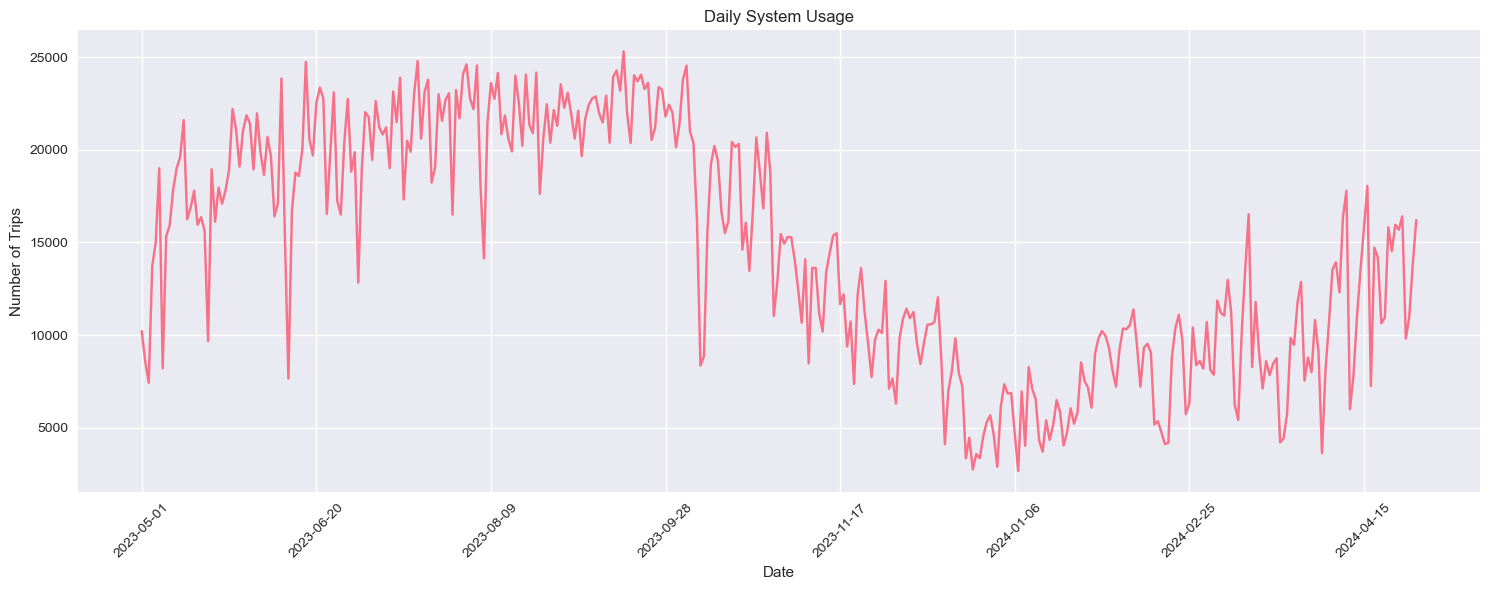


Station Analysis

Top 10 Busiest Stations:
                                  count      sum      mean       std
Station_Name                                                        
Bay St / College St (East Side)    8784  43022.0  4.897769  4.961702
King St W / Brant St               8784  42493.0  4.837546  5.417923
Union Station                      8784  39692.0  4.518670  4.753073
York St / Queens Quay W            8784  39284.0  4.472222  5.998721
Bay St / Wellesley St W            8784  37194.0  4.234290  4.402806
Queen St W / John St               8784  33759.0  3.843238  4.291140
Dundas St W / Yonge St             8784  32538.0  3.704235  4.578706
College Park - Yonge St Entrance   8784  32081.0  3.652209  3.788236
Richmond St E / Yonge St           8784  31650.0  3.603142  4.149936
Simcoe St / Queen St W             8784  31223.0  3.554531  4.181767


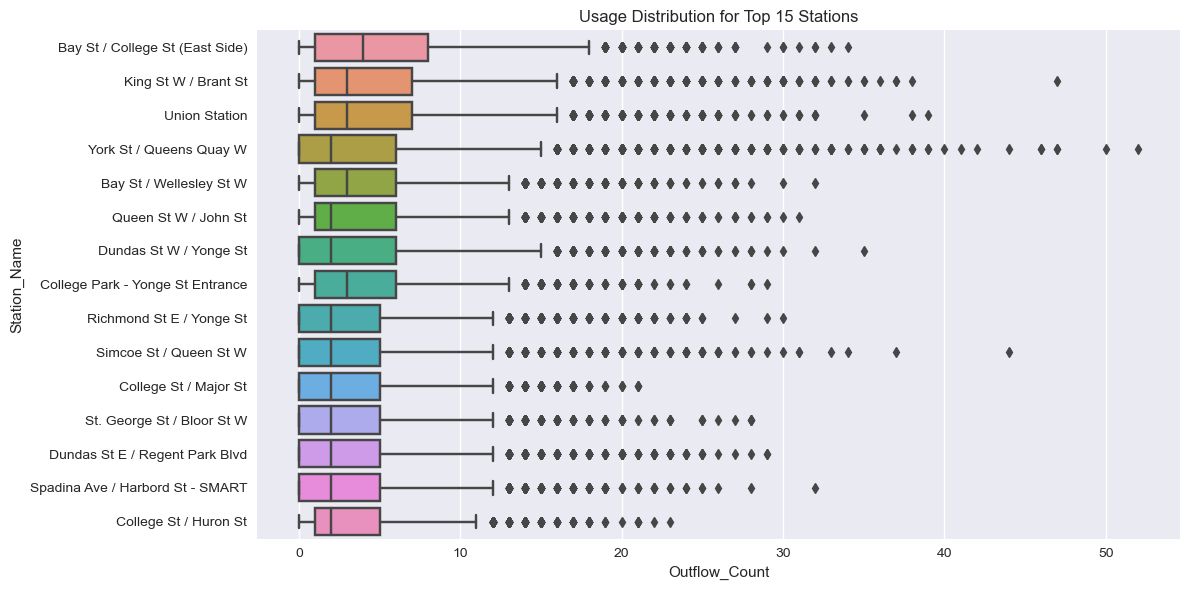


Temporal Patterns by User Type


<Figure size 1200x600 with 0 Axes>

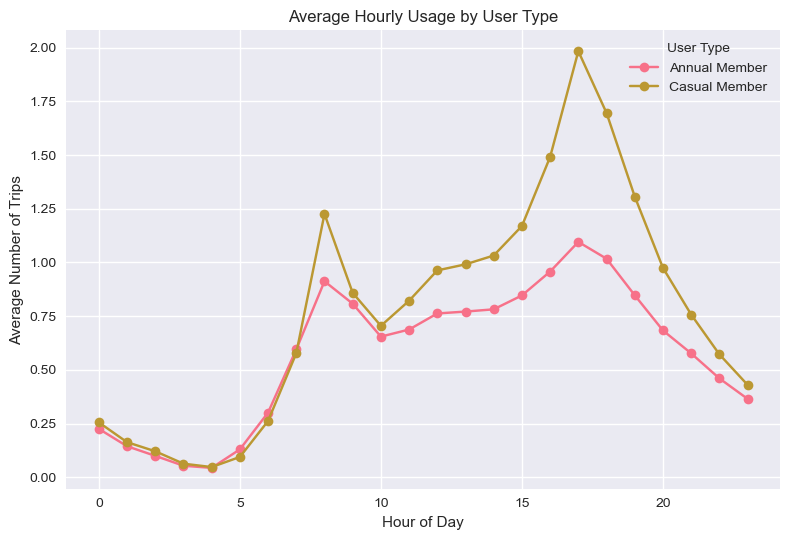

<Figure size 1200x600 with 0 Axes>

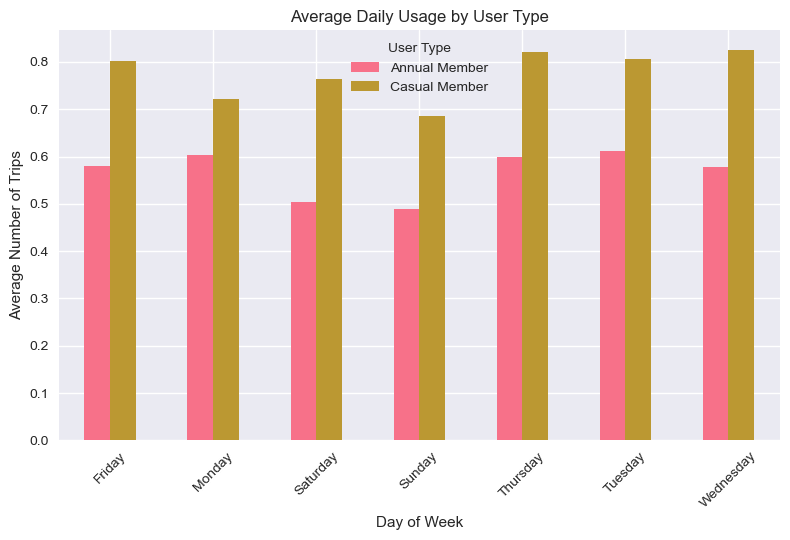


Weather Impact Analysis

Correlations with Usage:
Outflow_Count        1.000000
Temperature          0.173880
Dew Point            0.147694
Pressure             0.013557
Precipitation       -0.019541
Cloud Cover         -0.028732
Wind Speed          -0.042877
Relative Humidity   -0.048171
Name: Outflow_Count, dtype: float64


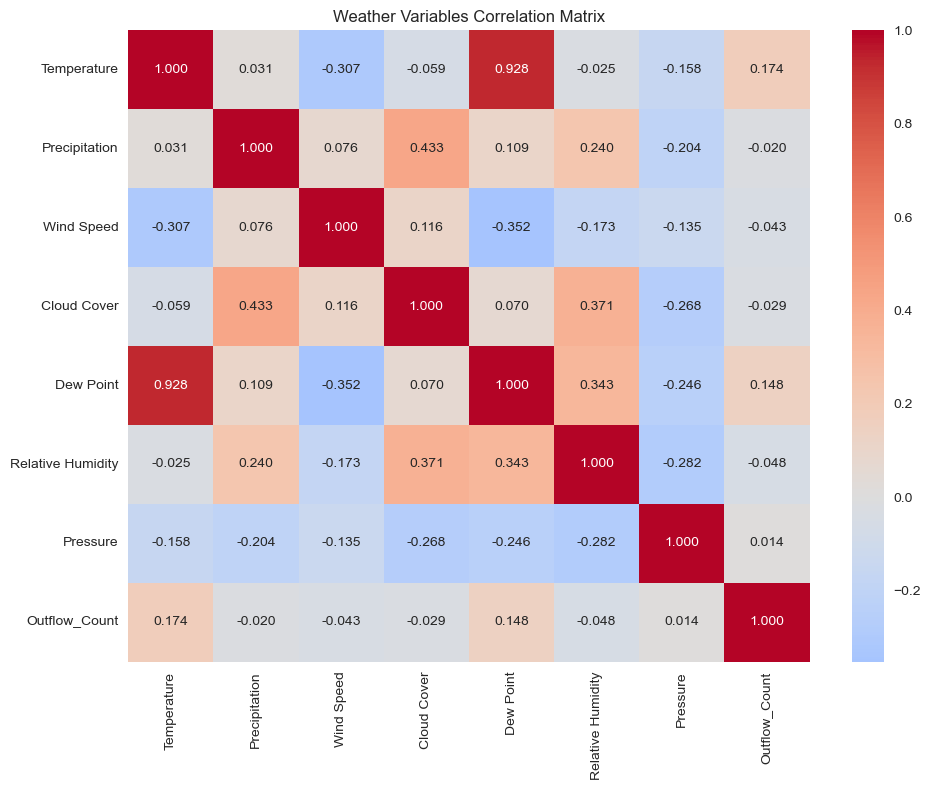

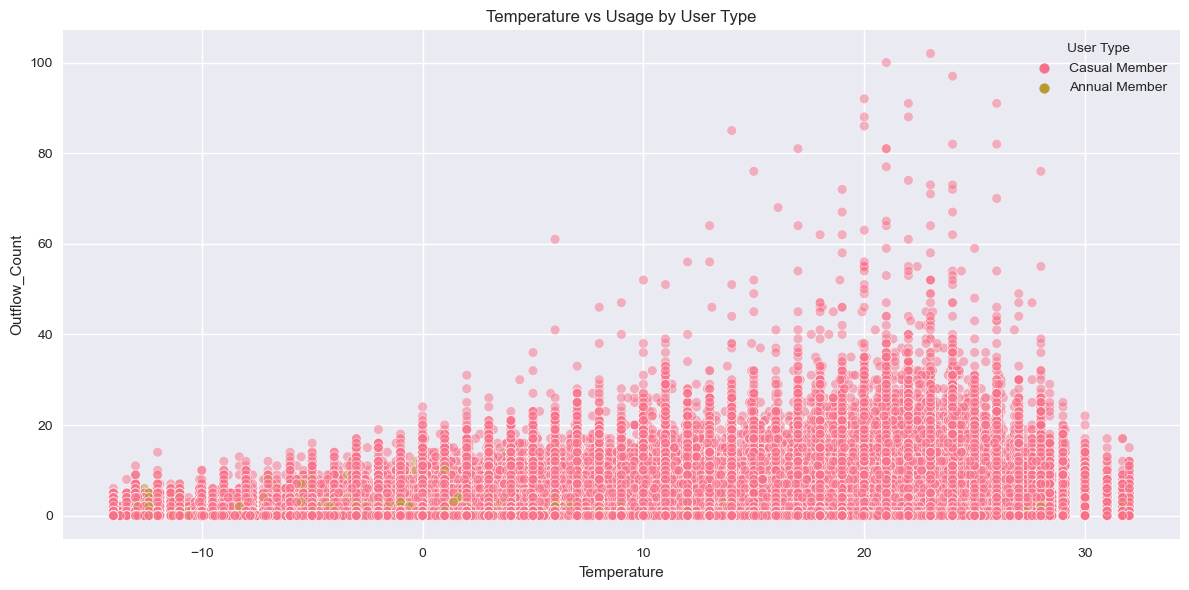


Geographic Distribution


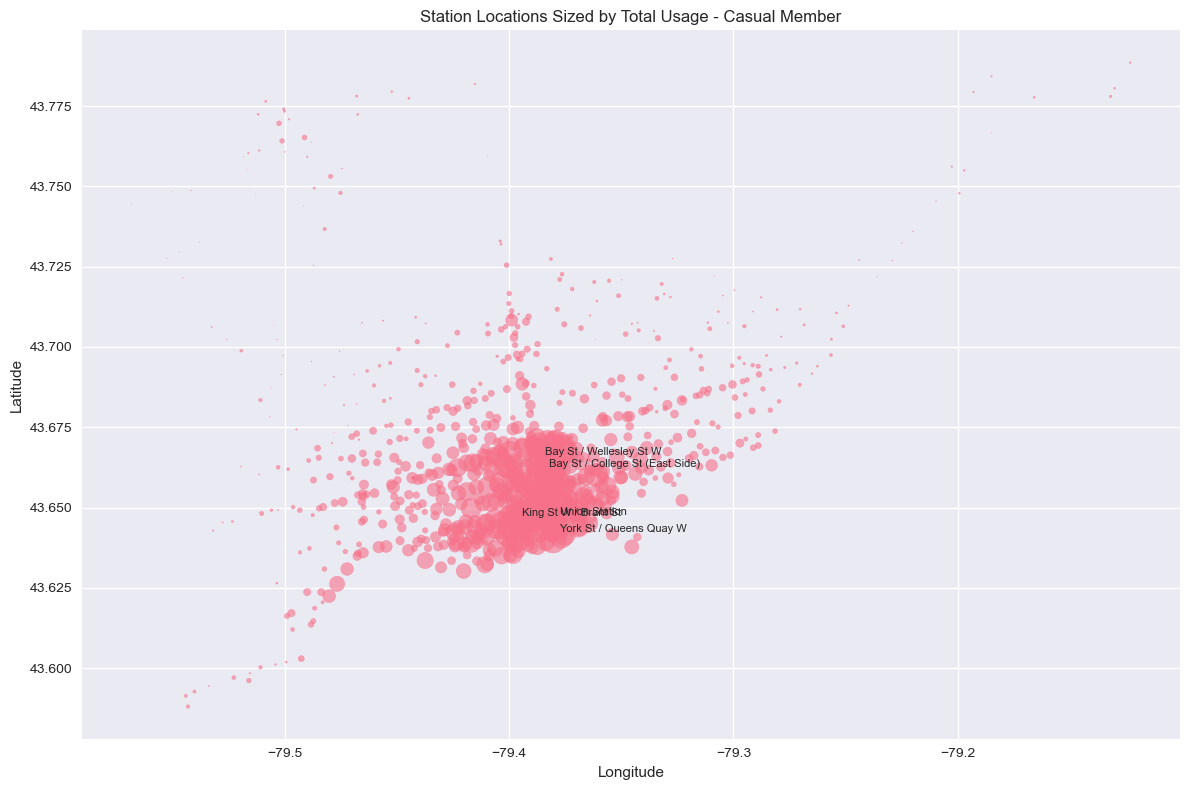

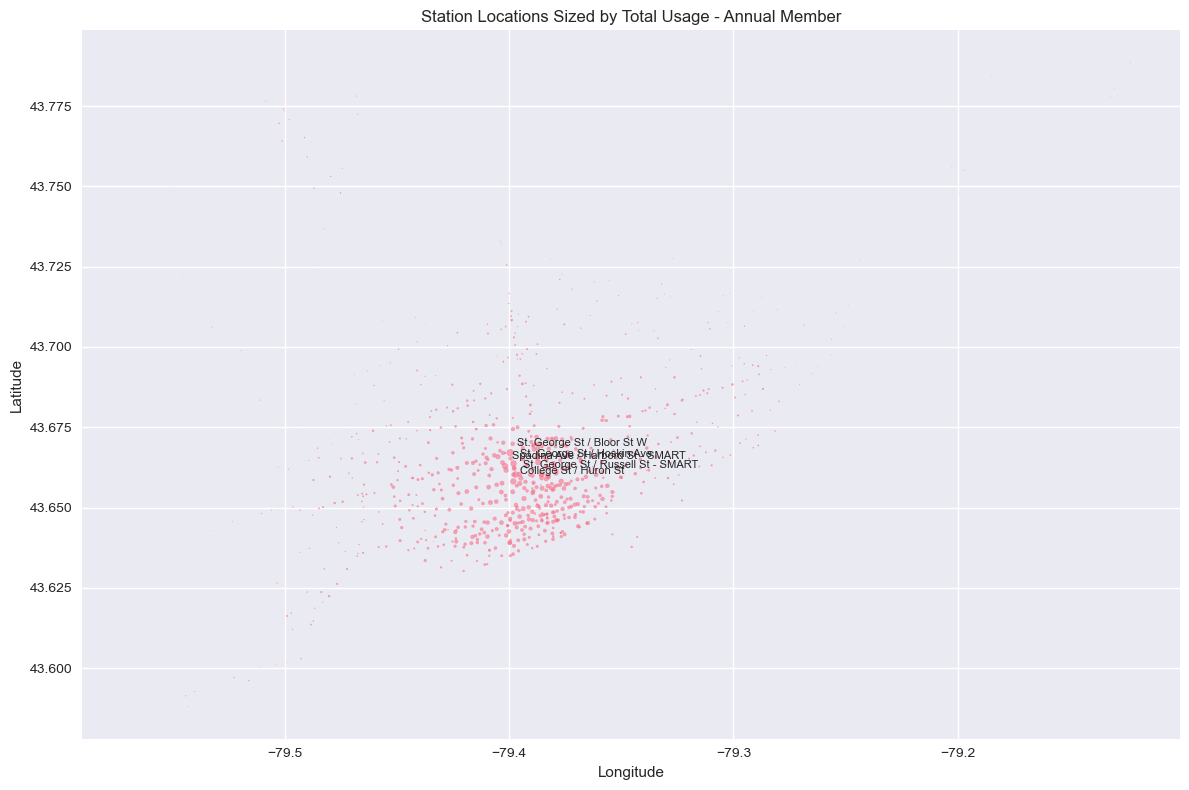

In [16]:
#analyze specific aspects
perform_eda(df)